<a href="https://colab.research.google.com/github/tpezzin/rna/blob/main/PerceptronXRL_multiclasse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tentei escolher as melhorias características de modo que fosse possível separá-las

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

data = load_iris()

X = data.data[:, 2:4]
y = data.target
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.75)

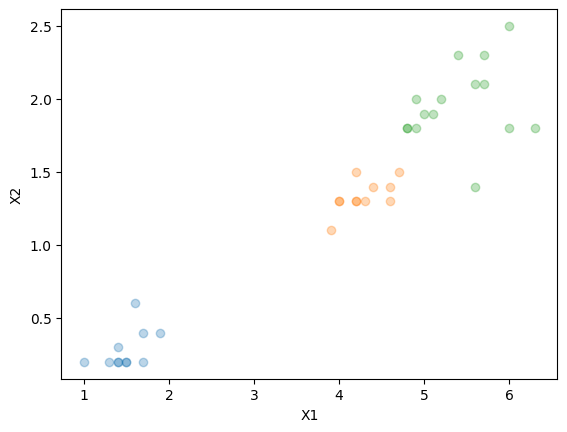

In [2]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

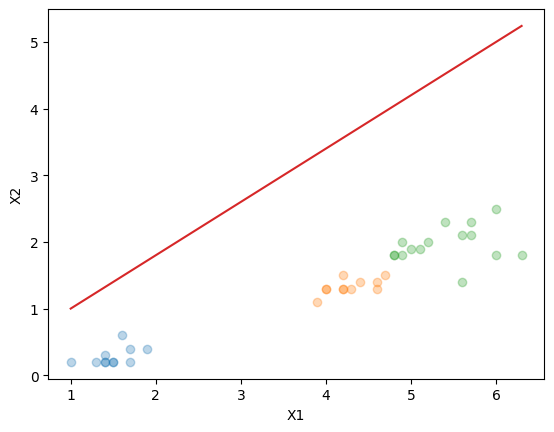

In [3]:
def plotaHiperplanoDatasetBidimensional(X, vetor, intercept=0):
    """
    Plota um definido por um
    vetor e o valor em que este vetor 
    intercepta o eixo vertical.
    """
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plt.plot(xs,ys)

plotaDatasetBidimensional(Xtr, ytr)
vetor_hyperplano = np.array([4, 5]) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, vetor_hyperplano, 1)

In [4]:
def sign(a):
    return (a >= 0) * 2 - 1

def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [5]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

from scipy.special import expit

class LogLikelihood(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(- y * ypred)))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - (expit(ypred)*2-1))

In [6]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation):
    pass

class PseudoInversa(TrainingAlgorithm):
  def __init__(self, regularization=0):
    self.regularization = regularization
  def getW(self, X, y):
    return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y


class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=100, learning_rate=0.05, 
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = X @ w
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w

0.5945945945945946
[[  7.44345293  -3.57166686 -21.4996644 ]
 [ -1.98659365   4.37197488  -1.82653919]
 [ -2.69543984  -6.31198362  13.36417369]]


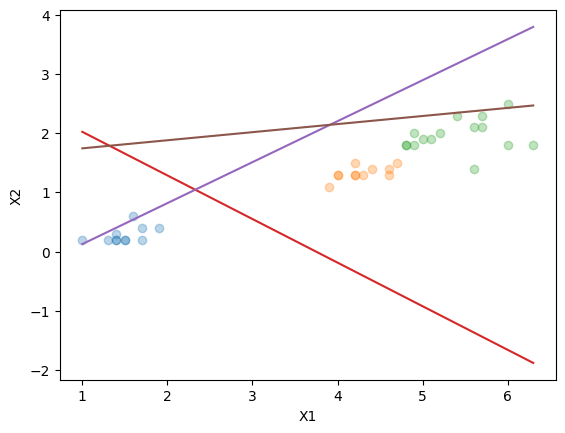

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.w = None
    self.training_algorithm = training_algorithm

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)*2-1

  def fit(self, X, y):
    Xb = include_bias(X)
    yhot = self.encode_labels(y)
    self.w = self.training_algorithm.getW(Xb, yhot)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict(self, X):
    a = self.__pre_activation(X)
    if self.w.shape[1] == 1:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=LogLikelihood()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)

if perceptron.w.shape[1] == 1:
  plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:], perceptron.w[0])
else:
  for i in range(perceptron.w.shape[1]):
    plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])

0.2972972972972973 0.34513274336283184
[[-2.02308693e+82  2.15793742e+82  1.51351534e+82]
 [-9.32136652e+82  9.94268974e+82  6.97351705e+82]
 [-3.18032527e+82  3.39231242e+82  2.37927051e+82]]


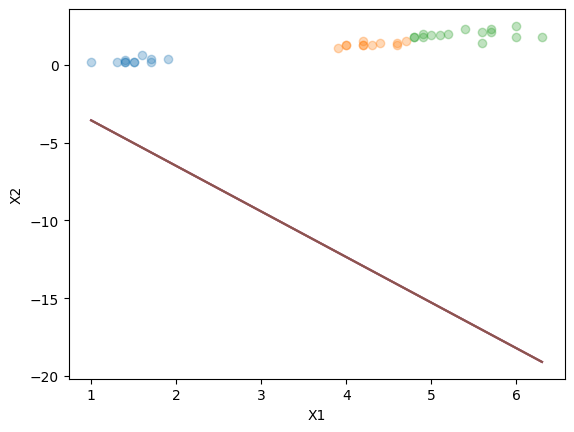

0.7027027027027027 0.6548672566371682
[[ 0.80778257 -1.11636401 -3.07057606]
 [-0.39929904 -1.1821908   0.24746161]
 [ 0.14658439 -1.74202343  1.25463327]]


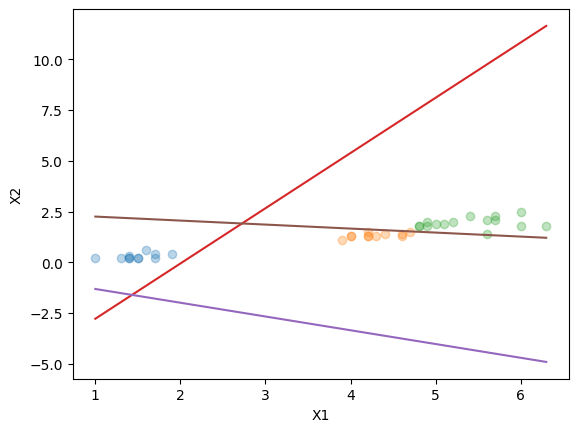

0.7027027027027027 0.6548672566371682
[[ 2.77518288 -1.63879386 -3.40680239]
 [-0.87931887  0.12411898  0.53375309]
 [-0.26766911 -1.27912223  2.24958218]]


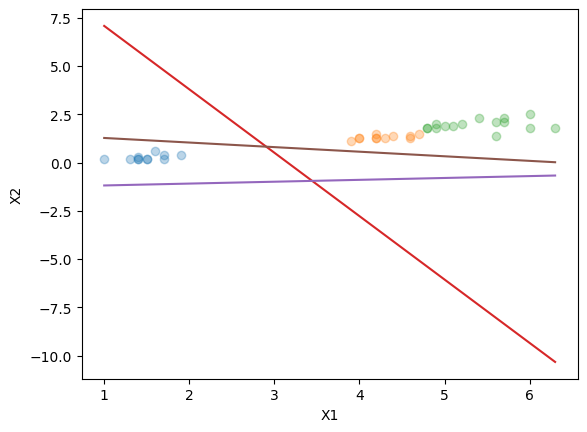

0.918918918918919 0.9380530973451328
[[ 4.24849722 -1.32405515 -4.84147999]
 [-1.29576414  0.27166989 -0.48268459]
 [-1.37718468 -0.70356846  3.6149338 ]]


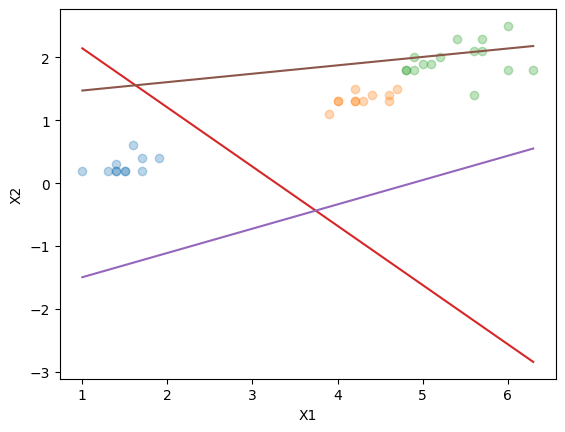

In [8]:
custos = [WidrowHoff(), SmoothedSurrogate(), HingeLoss(), LogLikelihood()]

for custo in custos:
    
    perceptron = Perceptron(training_algorithm=DescidaGradiente(learning_rate=0.01, regularization=0, cost=custo))
    perceptron.fit(Xtr, ytr)
    print(accuracy(ytr, perceptron.predict(Xtr)), accuracy(yte, perceptron.predict(Xte)))
    print(perceptron.w)
    plotaDatasetBidimensional(Xtr, ytr)
    if perceptron.w.shape[1] == 1:
            plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:], perceptron.w[0])
    else:
        for i in range(perceptron.w.shape[1]):
            plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])
    plt.show()

###Comparando o resultado com a Regressão Logistica

1.0 0.9380530973451328
[[-1.84069367 -0.71613179]
 [ 0.02313138 -0.53981552]
 [ 1.81756229  1.2559473 ]]
[ 7.49421492  1.90078183 -9.39499675]


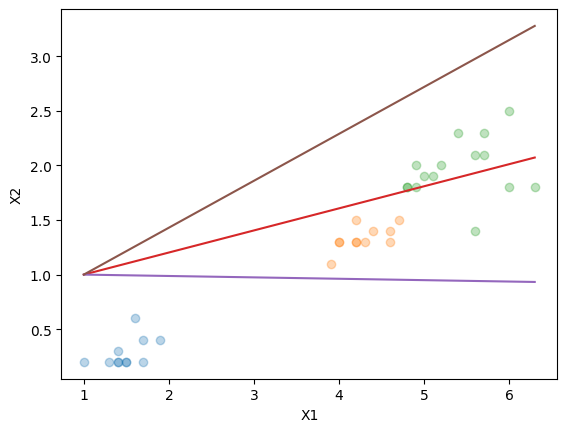

In [9]:
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression()
modelo.fit(Xtr, ytr)

print(accuracy(ytr, modelo.predict(Xtr)), accuracy(yte, modelo.predict(Xte)))
print(modelo.coef_)
print(modelo.intercept_)
plotaDatasetBidimensional(Xtr, ytr)

plotaHiperplanoDatasetBidimensional(Xtr, modelo.intercept_[1:], modelo.intercept_[0])
for i in range(modelo.coef_.shape[1]):
  plotaHiperplanoDatasetBidimensional(Xtr, modelo.coef_[1:,i], modelo.coef_[0,i])
plt.show()